<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/ml_batch/time_stepper_direct_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Direct solver

In [ ]:
pip install pyDOE

In [ ]:
pip install torchdyn

In [44]:
from argparse import ArgumentParser
from numpy import double
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss
import numpy as np
import torch
from torchdyn.numerics import odeint
import pandas as pd
import time
# from torchdyn.numerics.solvers import SolverTemplate

In [45]:
# Make device agnostic code 
device = "cuda" if torch.cuda.is_available() else "cpu"

In [46]:
# Clone my repository to have access to code inside utilis
!git clone https://github.com/juanmggb/maestria.git

Cloning into 'maestria'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 253 (delta 19), reused 21 (delta 8), pack-reused 203
Receiving objects: 100% (253/253), 6.32 MiB | 16.63 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [ ]:
cd maestria

In [51]:
ls

case_studies/  mc_continuous/       ml_fb/                 utilis/
data/          mc_fb/               ml_fb_optimization/
maestria/      mc_fb_optimization/  parameter_estimation/
mc_batch/      ml_batch/            README.md


In [53]:
# Import functions from my utilis package
from utilis.functions import create_initial_cond, plot_trajectory, plot_predictions, create_time_span
from utilis.models import fnn_model, inhibition_model_nn
from utilis.solvers import DirectSolver

Latin hypercube sampling (LHS) is a method for sampling a multi-dimensional space in a structured way such that each sample is as representative as possible of the space as a whole. It is called a "Latin" hypercube because it is a generalization of the Latin square, a type of matrix used in statistical design and analysis.

In LHS, the range of each dimension is divided into equal intervals, and then a single point is chosen randomly from each interval. This generates a set of samples that covers the entire range of the multi-dimensional space, with a more even distribution of points than would be achieved by simple random sampling.

LHS is often used in computer simulations and statistical modeling to generate a representative sample of a complex space in a computationally efficient way. It can be particularly useful when the dimensions of the space are highly correlated, or when the distribution of the data is non-uniform.

1. Create initial condtions for training 

    * 100 initial contions 
    * biomass concentrations goes from 0.2 to 10 g/L
    * substrate concentration goes from 0 to 40 g/L
    * product concentration goes from 0 to 40 g/L

In [88]:
# Initial condtions for training
x0_train = create_initial_cond(100, 0.2, 9.8, 0, 40, 0, 40)
print(x0_train[:5])
print(x0_train.shape)

tensor([[ 5.9701, 36.9115, 35.4973],
        [ 0.5603, 30.0966, 22.4872],
        [ 8.5027, 39.6608,  8.7363],
        [ 3.9400, 32.3621, 27.8997],
        [ 4.1100, 26.7720, 13.7468]], dtype=torch.float64)
torch.Size([100, 3])


2. Create initial conditions for validation
    * 10 initial conditions 
    * biomass concentrations goes from 0.2 to 6 g/L
    * substrate concentration goes from 15 to 35 g/L
    * product concentration goes from 0 to 0 g/L

In [89]:
# Initial conditions to model validation
x0_validate = create_initial_cond(10, 1, 5, 15, 20, 0, 0)
print(x0_validate[:5])
print(x0_validate.shape)

tensor([[ 4.9028, 27.8890,  0.0000],
        [ 1.1905, 21.0739,  0.0000],
        [ 1.6789, 18.4511,  0.0000],
        [ 4.1182, 34.8159,  0.0000],
        [ 3.5912, 25.8683,  0.0000]], dtype=torch.float64)
torch.Size([10, 3])


3. Create time span for training
    * It is a time span of 1 hour

4. Create time span for validations 
    * It is a time span of 60 hours 

In [90]:
# training time are time intervals of 1 hour
t_span_train = create_time_span(0, 1, 1)
# validation time are time intervals of 60 hours
t_span_validate = create_time_span(0, 60, 1)

5. Generate training trajectories
    * Each trajectory consists on the initial conditions and one step haead
    * RK4 is used to generate trajectories

In [91]:
# Calculate state at hour 1 with training initial conditions
# This is equivalen to experimental data
_, x_train = odeint(inhibition_model_nn, x0_train, t_span_train, solver="rk4")
print(x_train.shape)

torch.Size([2, 100, 3])


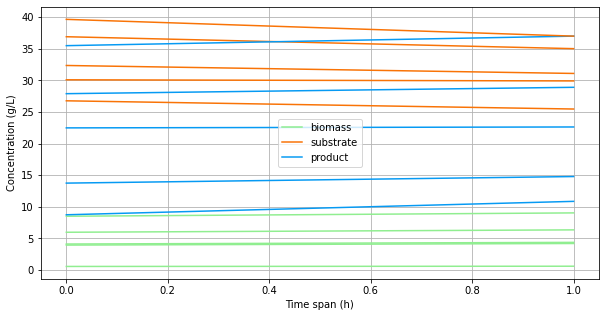

In [92]:
# Plot trajectory i from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_train)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

6. Generate validation trajectories 
    * Each trajectory consists of 60 observations, starting with the initial condition
    * RK4 is used to generate trajectories 

In [93]:
# Calculate trajectory for initial conditions in validation data
_, x_validate = odeint(inhibition_model_nn, x0_validate, t_span_validate, solver="rk4")
print(x_validate.shape)

torch.Size([61, 10, 3])


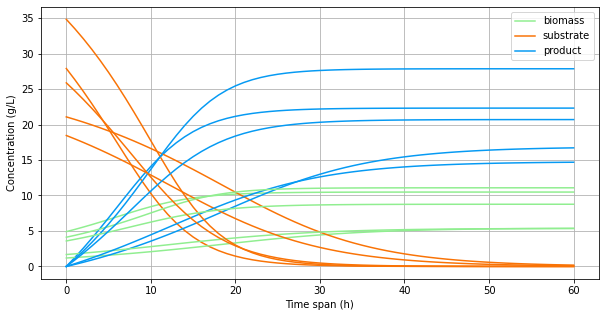

In [94]:
# Plot trajectory n from 100 training trajectories
plt.figure(figsize=(10, 5))
for i in range(5):    
    plot_trajectory(i, x_validate)
plt.xlabel('Time span (h)')
plt.ylabel('Concentration (g/L)')
plt.grid()
plt.legend()
plt.show()

7. Generate ANN model 
    
    * 7.1 One input layer with three neurons

    * 7.2 Eight hidden layers with 32 neurons 

      * Each hidden layer consists of a Linear layer with a Softplus activations functions 

    * 7.3 The output has three neurons 
        * The output layer is a simple Linear layer without activation function

    * 7.4 The weights and biases of the ANN are randomly initialized 


In [95]:
# Create model
net = fnn_model(3, 3, 32, 8)

8. The optimization algorithm for training is Adam 

Adam (Adaptive Moment Estimation) is an optimization algorithm commonly used in deep learning. It combines the advantages of two other popular optimization algorithms, SGD (Stochastic Gradient Descent) and RMSprop (Root Mean Squared Propagation), and has been shown to work well in a wide range of applications.

The Adam optimization algorithm uses estimates of the first and second moments of the gradients to scale the learning rate adaptively. This can help the optimizer converge more quickly and avoid oscillations or divergences that can occur with other optimization algorithms. It also includes a learning rate decay schedule, which decreases the learning rate over time to help the optimizer converge to a more optimal solution.

In [96]:
# training algorithm
optimizer = Adam(net.parameters()) 

9. The loss function is the MSE

10. During training the loss function for the training and the validation data is calculated

11. The training occurs by two thousand epochs 

In [97]:
strat_time = time.time()
# training
losses = []

epochs = 2000

for epoch in tqdm(range(epochs)): 

    net.train()

    # 1. Forward pass
    _, x_pred_train = odeint(
        lambda t, x: net(x),
        x0_train,
        t_span_train, 
        solver=DirectSolver()
    )

    # 2. Calculate loss
    loss = mse_loss(x_pred_train, x_train) 

    # 3. Zero grad
    optimizer.zero_grad() 
    
    # 4. Backward pass
    loss.backward()
    losses.append(loss.item())

    # 5. Update weights and biases
    optimizer.step() 

    # Validation data
    # net.eval()
    # with torch.inference_mode():

    #     # 1. Forward pass
    #     _, x_pred_validate = odeint(
    #         lambda t, x: net(x), 
    #         x0_validate, 
    #         t_span_validate, 
    #         solver=DirectSolver()
    #     )

    #     # 2. Calculate loss
    #     loss_val = mse_loss(x_pred_validate, x_validate) 
    
    if epoch % 50 == 0:

        # print(f"Epoch: {epoch} | Training loss: {loss} | Validate loss: {loss_val}")
        print(f"Epoch: {epoch} | Training loss: {loss}")
end_time = time.time()

  0%|          | 2/2000 [00:00<03:01, 11.03it/s]

Epoch: 0 | Training loss: 181.93130878251932


  4%|▍         | 86/2000 [00:00<00:08, 218.55it/s]

Epoch: 50 | Training loss: 22.548685464464825
Epoch: 100 | Training loss: 4.096134765239029


 10%|▉         | 196/2000 [00:00<00:06, 261.27it/s]

Epoch: 150 | Training loss: 1.3092966502219656
Epoch: 200 | Training loss: 0.09765559920614353


 14%|█▍        | 284/2000 [00:01<00:06, 272.51it/s]

Epoch: 250 | Training loss: 0.03799326302398216
Epoch: 300 | Training loss: 0.02420165701853223


 20%|██        | 401/2000 [00:01<00:05, 283.05it/s]

Epoch: 350 | Training loss: 0.016639178126713623
Epoch: 400 | Training loss: 0.010650519080272973


 25%|██▍       | 494/2000 [00:01<00:05, 295.29it/s]

Epoch: 450 | Training loss: 0.007947723683892578
Epoch: 500 | Training loss: 0.03366215768506578


 30%|██▉       | 590/2000 [00:02<00:04, 307.21it/s]

Epoch: 550 | Training loss: 0.004642562072176854
Epoch: 600 | Training loss: 0.009881523094652926


 34%|███▍      | 683/2000 [00:02<00:04, 305.69it/s]

Epoch: 650 | Training loss: 0.0030825901512067174
Epoch: 700 | Training loss: 0.0025619168162845747


 40%|████      | 806/2000 [00:02<00:04, 285.83it/s]

Epoch: 750 | Training loss: 0.0021934647376749637
Epoch: 800 | Training loss: 0.02427360485682259


 45%|████▍     | 893/2000 [00:03<00:03, 282.15it/s]

Epoch: 850 | Training loss: 0.0018747246456762825
Epoch: 900 | Training loss: 0.0016424962333666255


 49%|████▉     | 984/2000 [00:03<00:03, 283.66it/s]

Epoch: 950 | Training loss: 0.0014710030515533376
Epoch: 1000 | Training loss: 0.0013328963876994193


 55%|█████▌    | 1103/2000 [00:04<00:03, 285.66it/s]

Epoch: 1050 | Training loss: 0.005634084892498271
Epoch: 1100 | Training loss: 0.0013902888151294834


 60%|█████▉    | 1191/2000 [00:04<00:02, 283.72it/s]

Epoch: 1150 | Training loss: 0.0011732316314406906
Epoch: 1200 | Training loss: 0.0010673125416597413


 64%|██████▍   | 1282/2000 [00:04<00:02, 293.66it/s]

Epoch: 1250 | Training loss: 0.0009841829417224972
Epoch: 1300 | Training loss: 0.0009149168996797337


 70%|███████   | 1404/2000 [00:05<00:02, 286.00it/s]

Epoch: 1350 | Training loss: 0.0324650323434985
Epoch: 1400 | Training loss: 0.0011901940076756035


 75%|███████▍  | 1494/2000 [00:05<00:01, 258.13it/s]

Epoch: 1450 | Training loss: 0.000969203891897134


 78%|███████▊  | 1553/2000 [00:05<00:01, 272.88it/s]

Epoch: 1500 | Training loss: 0.0008685341850130624
Epoch: 1550 | Training loss: 0.0008023239674556341


 82%|████████▏ | 1641/2000 [00:05<00:01, 279.40it/s]

Epoch: 1600 | Training loss: 0.0007522113449740536
Epoch: 1650 | Training loss: 0.0007111853331010924


 87%|████████▋ | 1732/2000 [00:06<00:00, 293.93it/s]

Epoch: 1700 | Training loss: 0.0006759662077974955
Epoch: 1750 | Training loss: 0.06372463799593225


 93%|█████████▎| 1852/2000 [00:06<00:00, 287.37it/s]

Epoch: 1800 | Training loss: 0.0016904031886574367
Epoch: 1850 | Training loss: 0.0009435341036205728


 97%|█████████▋| 1942/2000 [00:07<00:00, 290.15it/s]

Epoch: 1900 | Training loss: 0.0007980937968219466
Epoch: 1950 | Training loss: 0.0007219524317761269


100%|██████████| 2000/2000 [00:07<00:00, 277.17it/s]


In [98]:
total_time = end_time - strat_time 
print(f"Total time: {total_time:.3f}s")

Total time: 7.231s


12. The minimum loss function achieved with the training data is  0.000429

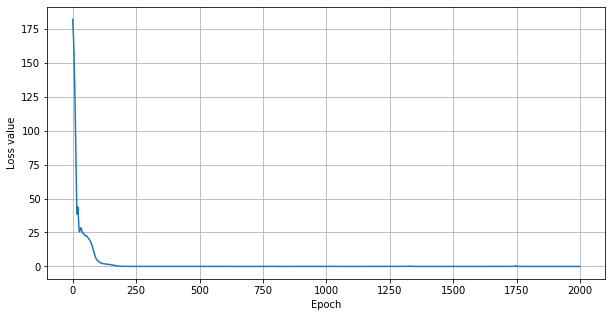

In [99]:
# Plot loss evolution 
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.grid()
plt.show()

In [100]:
# Make predictions 
net.eval()
with torch.inference_mode():
    _, x_pred_validate = odeint(lambda t, x: net(
        x), x0_validate, t_span_validate, solver=DirectSolver()
    ) 

In [101]:
print(x_pred_validate.shape)

torch.Size([61, 10, 3])


In [102]:
print(mse_loss(x_pred_validate, x_validate))

tensor(9.2089, dtype=torch.float64)


13. The minimum loss function achieved with the validation data is 18.1128

In [103]:
# In order to plot predictions we need a numpy array
x_pred_validate = x_pred_validate.detach().numpy()

Validation 0


/content/maestria/utilis/functions.py:264: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:277: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:290: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

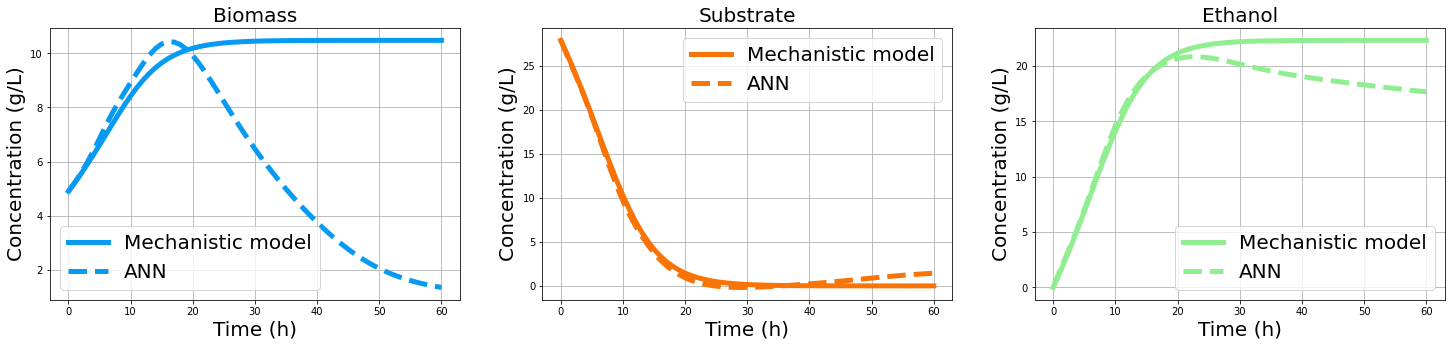

Validation 1


/content/maestria/utilis/functions.py:264: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:277: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:290: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

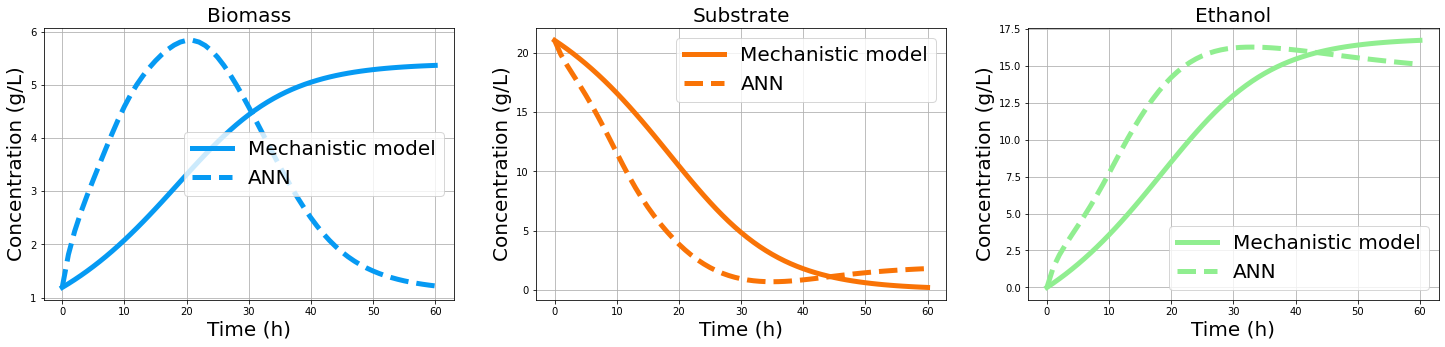

Validation 2


/content/maestria/utilis/functions.py:264: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:277: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:290: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

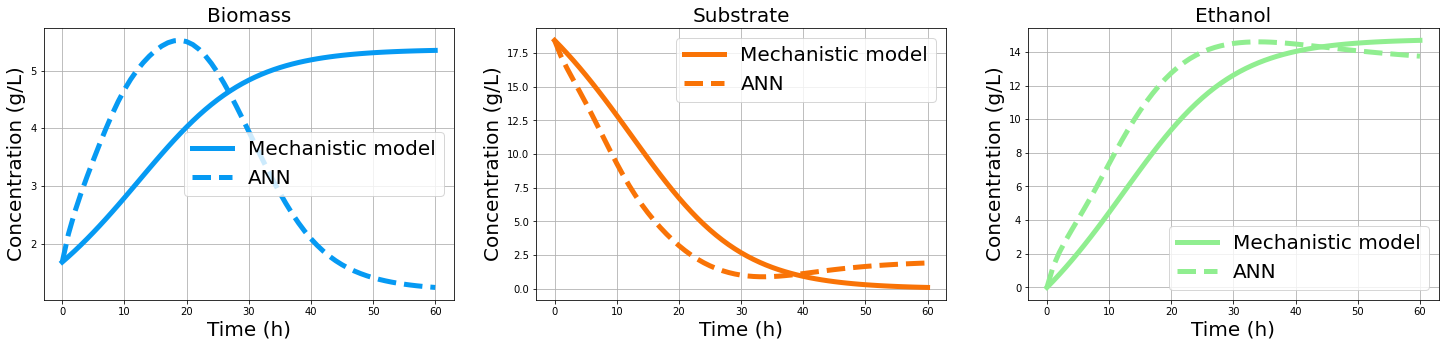

Validation 3


/content/maestria/utilis/functions.py:264: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:277: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:290: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

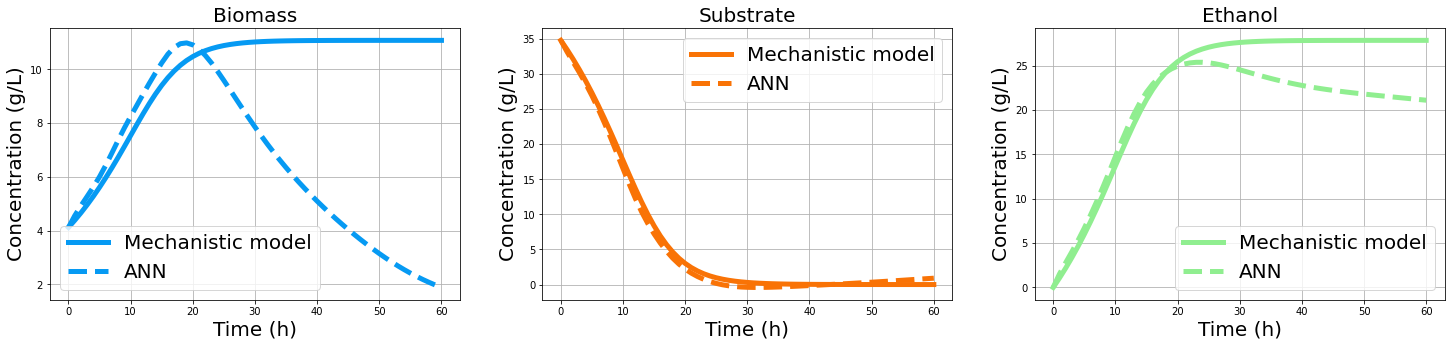

Validation 4


/content/maestria/utilis/functions.py:264: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
/content/maestria/utilis/functions.py:277: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
/content/maestria/utilis/functions.py:290: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

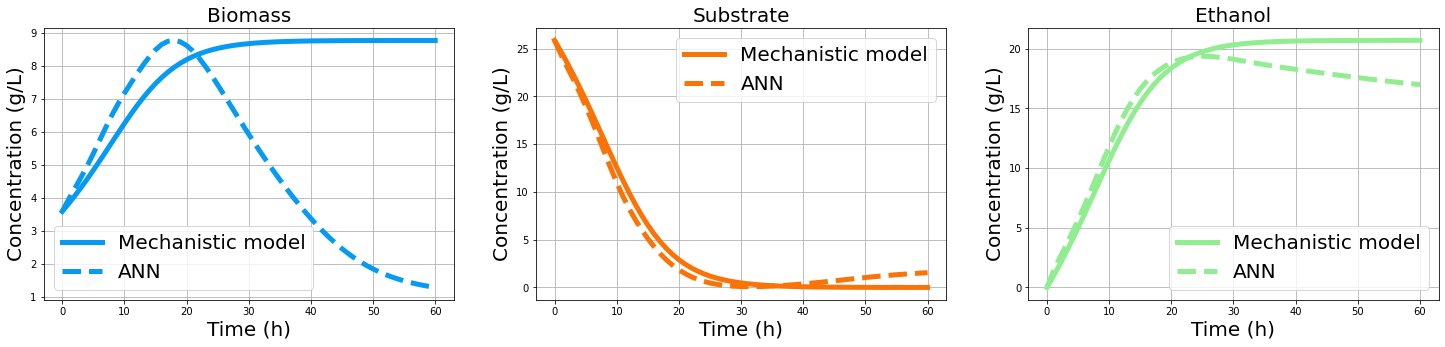

In [104]:
for i in range(5):
    plot_predictions(t_span_validate, x_validate, x_pred_validate, i)